<a href="https://colab.research.google.com/github/Vinni22Z/Sistema-de-Recomenda-o-de-Filmes-com-Machine-Learning/blob/main/Movie_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recomendação de Filmes com Naive Bayes e SMOTE


## 1. Contexto do Projeto
* O objetivo deste projeto é criar um modelo de Machine Learning capaz de prever se um usuário vai Gostar (1) ou Não Gostar (0) de um filme específico, com base em seu histórico de preferências.

* Fonte dos Dados: O projeto utiliza a base de dados MovieLens. Para esta análise, utilizamos apenas o arquivo ratings.dat, que contém as interações e notas dadas pelos usuários aos filmes.

* O Problema de Negócio: Sistemas de recomendação precisam ser precisos. Recomendar um filme ruim frustra o usuário, enquanto deixar de recomendar um filme bom é oportunidade perdida. O desafio principal é lidar com dados desbalanceados, visto que filmes populares acumulam muito mais avaliações positivas.

* A Solução: A abordagem escolhida é o algoritmo Multinomial Naive Bayes, aprimorado com SMOTE para balanceamento de classes e GridSearch para otimização de hiperparâmetros.




In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix , classification_report , roc_curve , roc_auc_score , accuracy_score


In [101]:
dados = 'ratings.dat'

In [102]:
df = pd.read_csv(dados,header=None,sep="::",engine='python')

In [103]:
df.columns = ['ID_Cliente','ID_Filme','Nota','Time']

In [104]:
df

,ID_Cliente,ID_Filme,Nota,Time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [105]:
df.isnull().sum()

,0
ID_Cliente,0
ID_Filme,0
Nota,0
Time,0


In [106]:
df['Nota'].describe()

,Nota
count,1.000209e+06
mean,3.581564e+00
std,1.117102e+00
min,1.000000e+00
25%,3.000000e+00
50%,4.000000e+00
75%,4.000000e+00
max,5.000000e+00


In [107]:
df['ID_Filme'].value_counts()

,count
ID_Filme,
2858,3428
260,2991
1196,2990
1210,2883
480,2672
...,...
872,1
2703,1
2845,1


In [108]:
n_cliente = df['ID_Cliente'].nunique()
n_filme = df['ID_Filme'].nunique()
print(f'clientes unicos: {n_cliente}')
print(f'filmes unicos: {n_filme}')

clientes unicos: 6040
filmes unicos: 3706


##2.Engenharia de Atributos


Os dados originais estavam estruturados em formato transacional, onde cada linha representa uma avaliação individual contendo: ID do usuário, ID do filme, nota e timestamp. Para que o modelo pudesse aprender padrões de preferência, foi necessário transformar essa estrutura em um formato matricial adequado para algoritmos supervisonados.

##2.1Construção da Matriz Usuário × Filme

Utilizamos uma tabela pivô para reestruturar o dataset. A matriz gerada possui:

Linhas: usuários (ID_Cliente)

Colunas: filmes (ID_Filme)

Valores: notas atribuídas pelos usuários aos filmes

Como a grande maioria dos usuários não avaliou a maior parte dos filmes, a matriz apresenta altíssima proporção de valores ausentes. Esses valores foram preenchidos com 0, indicando “não avaliou”.

In [109]:
df1 = df.pivot(index='ID_Cliente', columns='ID_Filme',values= 'Nota')
df1

ID_Filme,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
ID_Cliente,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
df1 = df1.fillna(0).astype(int)
df1

ID_Filme,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
ID_Cliente,,,,,,,,,,,,,,,,,,,,,
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0,0,0,2,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6037,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6038,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [111]:

# Pega todos os números da matriz pivotada e transforma em uma linha única
todas_as_notas = df1.values.flatten()

# Agora transformamos em series e contamos
contagem = pd.Series(todas_as_notas).value_counts().sort_index()

print(contagem)

0    21384031
1       56174
2      107557
3      261197
4      348971
5      226310
Name: count, dtype: int64


##2.2. Seleção e Criação do Alvo (y)

O filme analisado como alvo do modelo foi o filme 2858 — American Beauty.

As etapas foram:

Selecionamos apenas os usuários que avaliaram esse filme, removendo usuários com nota 0 (não assistiram).

Criamos uma variável alvo binária, definindo se o usuário gostou ou não gostou do filme:

1 — Gostou: notas 4 e 5

0 — Não gostou: notas 1, 2 ou 3

Essa transformação permite que o modelo opere como um classificador binário previsível e interpretável.

In [112]:
y = df1[2858]
X = df1.drop(columns=2858 , axis=1 )

##2.3. Preparação da Matriz de Atributos (X)

Para evitar vazamento de informação, removemos da matriz de atributos a coluna correspondente ao próprio filme-alvo (ID 2858).
Assim, o modelo não tem acesso direto à nota que quer prever.

In [113]:
linhas_validas = y > 0
y_filtrado = y[linhas_validas]
X_filtrado = X[linhas_validas]

y_final = (y_filtrado > 3).astype(int)
X_final = X_filtrado


print("Tamanho final para treino:", X_final.shape)

print("Distribuição do alvo (0 vs 1):")

print(y_final.value_counts())


Tamanho final para treino: (3428, 3705)
Distribuição do alvo (0 vs 1):
2858
1    2853
0     575
Name: count, dtype: int64


In [114]:
X_train , X_test , y_train , y_test = train_test_split(X_final,y_final,test_size=0.2,random_state=42,stratify=y_final)

print(len(X_train))
print(len(X_test))

2742
686


### Modelo Baseline

In [115]:
clf = MultinomialNB(alpha=1.0 , fit_prior=True)
clf.fit(X_train,y_train)

MultinomialNB()

In [116]:
y_pred = clf.predict(X_test)
print(y_pred[:10])

[1 0 1 1 1 1 1 0 0 1]


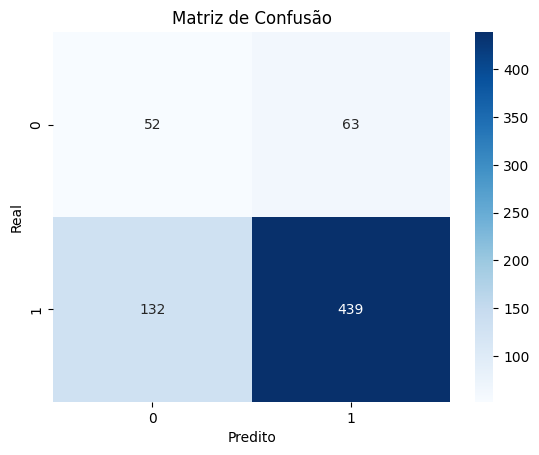

In [117]:
cm = confusion_matrix(y_test , y_pred )

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.show()

In [118]:
report = classification_report(y_test,y_pred)
print(report)

acuracia = clf.score(X_test,y_test)
print('Acuracia : ',acuracia)

              precision    recall  f1-score   support

           0       0.28      0.45      0.35       115
           1       0.87      0.77      0.82       571

    accuracy                           0.72       686
   macro avg       0.58      0.61      0.58       686
weighted avg       0.78      0.72      0.74       686

Acuracia :  0.7157434402332361


0.6449782989415975


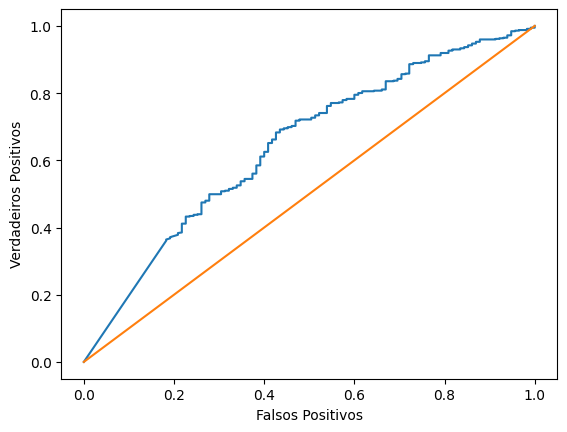

In [119]:
y_prob = clf.predict_proba(X_test)[:,1]
fpr , tpr ,thresholds = roc_curve(y_test , y_prob)

plt.plot(fpr,tpr,)
plt.plot([0, 1], [0, 1],)
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdadeiros Positivos')



auc = roc_auc_score(y_test , y_prob)
print(auc)

## 3. Balanceamento de Classes com SMOTE


In [120]:
smote = SMOTE(random_state=42)

In [121]:
X_train_resampled , y_train_resampled = smote.fit_resample(X_train,y_train)

In [122]:
clf_SMOT = MultinomialNB(alpha=1.0 , fit_prior=True)
clf_SMOT.fit(X_train_resampled,y_train_resampled)

MultinomialNB()

In [123]:
y_pred_smot = clf_SMOT.predict(X_test)

In [124]:
cm_smot = confusion_matrix(y_test ,y_pred_smot )
print(cm_smot)

[[ 66  49]
 [199 372]]


In [125]:
report_smot = classification_report(y_test,y_pred_smot)
print(report_smot)

acuracia_smot = clf_SMOT.score(X_test,y_test)
print('Acuracia_smot : ',acuracia_smot)

              precision    recall  f1-score   support

           0       0.25      0.57      0.35       115
           1       0.88      0.65      0.75       571

    accuracy                           0.64       686
   macro avg       0.57      0.61      0.55       686
weighted avg       0.78      0.64      0.68       686

Acuracia_smot :  0.6384839650145773


0.6586994593771416


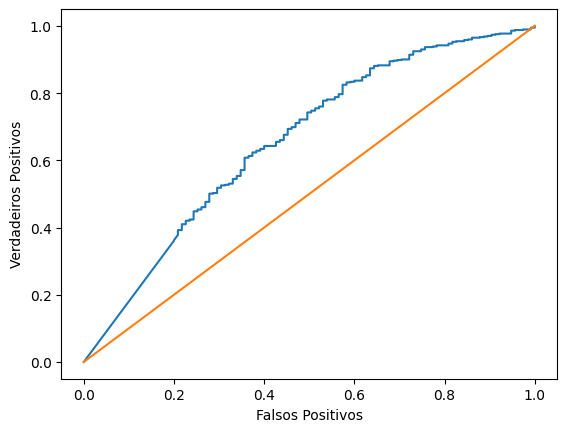

In [126]:
y_prob_smot = clf_SMOT.predict_proba(X_test)[:,1]
fpr , tpr ,thresholds = roc_curve(y_test , y_prob_smot)

plt.plot(fpr,tpr,)
plt.plot([0, 1], [0, 1] )
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdadeiros Positivos')



auc_smot = roc_auc_score(y_test , y_prob_smot)
print(auc_smot)

## 4. Otimização de Hiperparâmetros (GridSearch)


In [127]:
Param = {
    'alpha': [0.01 , 0.1, 0.5, 1.0, 5.0, 10.0],
    'fit_prior': [True,False]
}

grid_search = GridSearchCV(clf_SMOT,
                           Param,
                           cv=6,
                           scoring='roc_auc',
                           n_jobs=-1)


grid_search.fit(X_train_resampled,y_train_resampled)




GridSearchCV(cv=6, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0],
                         'fit_prior': [True, False]},
             scoring='roc_auc')

In [128]:
print(f"Melhores parâmetros: {grid_search.best_params_}")


Melhores parâmetros: {'alpha': 0.01, 'fit_prior': True}


In [129]:
Cv_clf = MultinomialNB(alpha=0.01 , fit_prior=True)
Cv_clf.fit(X_train_resampled,y_train_resampled)

MultinomialNB(alpha=0.01)

In [130]:
y_predCV = Cv_clf.predict(X_test)
y_probCV = Cv_clf.predict_proba(X_test)[:,1]

print('AUC :', roc_auc_score(y_test,y_probCV))
print('acuracia :', accuracy_score (y_test,y_predCV))
print('Matriz de Confusao :', confusion_matrix(y_test, y_predCV))

AUC : 0.6582273661768064
acuracia : 0.6486880466472303
Matriz de Confusao : [[ 64  51]
 [190 381]]


In [131]:
report_CV = classification_report(y_test,y_predCV)
print(report_CV)

              precision    recall  f1-score   support

           0       0.25      0.56      0.35       115
           1       0.88      0.67      0.76       571

    accuracy                           0.65       686
   macro avg       0.57      0.61      0.55       686
weighted avg       0.78      0.65      0.69       686



0.6582273661768064


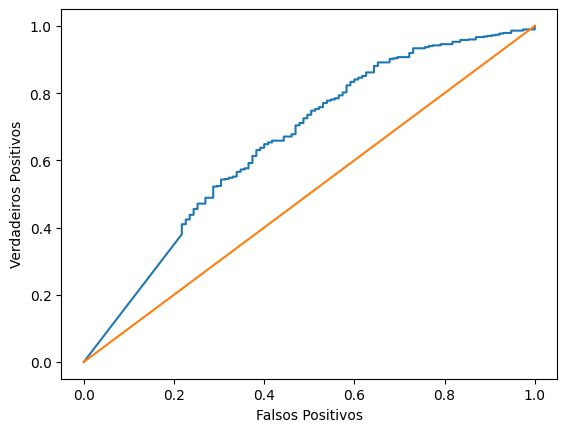

In [132]:

fpr , tpr ,thresholds = roc_curve(y_test , y_probCV)

plt.plot(fpr,tpr,)
plt.plot([0, 1], [0, 1] )
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdadeiros Positivos')



aucCV = roc_auc_score(y_test , y_probCV)
print(aucCV)

# 5. Conclusão

Neste projeto, colocamos frente a frente um modelo básico (*Baseline*) e uma versão turbinada, onde aplicamos técnicas de balanceamento (**SMOTE**) e ajuste fino (**GridSearch**). O objetivo era ver se conseguíamos tornar as recomendações mais inteligentes, não apenas mais frequentes.

###  Comparaçao dos Modelos:

| Métrica | Modelo Baseline (Sem SMOTE) | Modelo Final (SMOTE + GridSearch) | O que isso significa? |
| :--- | :--- | :--- | :--- |
| **Acurácia** | **72%** | 65% | A acurácia caiu, mas por um bom motivo: o modelo parou de "chutar" que todo mundo gosta de tudo só para acertar a maioria. |
| **AUC (Separação)** | 0.64 | **0.66** | Houve uma melhora leve na inteligência geral do modelo em separar o joio do trigo. |
| **Recall (Classe 0)** | 0.45 | **0.56** | **O grande ganho:** O modelo final ficou muito mais esperto para identificar os *haters* (quem não gosta do filme). |
| **Precision (Classe 1)** | 0.87 | **0.88** | A confiança na recomendação positiva continua altíssima. Se ele indica, é porque é bom. |

### Impacto Real no Negócio:

1.  **Recomendações de Confiança:**
    * Com uma precisão de **88%** para a classe positiva, o sistema virou um "curador exigente". Quando ele diz para o usuário assistir a um filme, a chance de acerto é enorme. Isso cria uma relação de confiança com a plataforma.

2.  **Menos Frustração para o Usuário:**
    * O salto no *Recall* da classe 0 (de 0.45 para 0.56) mostra que o modelo aprendeu a filtrar melhor o que é ruim. Ele está "protegendo" o usuário de filmes que o desagradariam.

3.  **O Preço da Qualidade (Trade-off):**
    * Para ser tão criterioso e evitar filmes ruins a todo custo, o modelo acabou ficando mais "tímido". Ele prefere pecar pelo excesso de cautela e deixar de recomendar alguns filmes bons (o que fez a acurácia geral cair) do que arriscar indicar uma bomba.

> **Veredito:** O modelo final é a melhor escolha para o negócio. Em sistemas de recomendação, a **confiança** é tudo. É muito menos grave o usuário deixar de ver um filme legal (porque não foi recomendado) do que ele assistir a um filme horrível por culpa nossa e sair frustrado. O modelo final garante uma experiência muito mais segura e satisfatória.